In [ ]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

: 

In [2]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.9.1')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [3]:
# load ruggedness data from Statistical Rethinking book
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]

In [4]:
# log transform response variable since it is highly skewed
# gdppc = GPP Per Capita
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [5]:
# convert np data array to a pytorch tensor
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

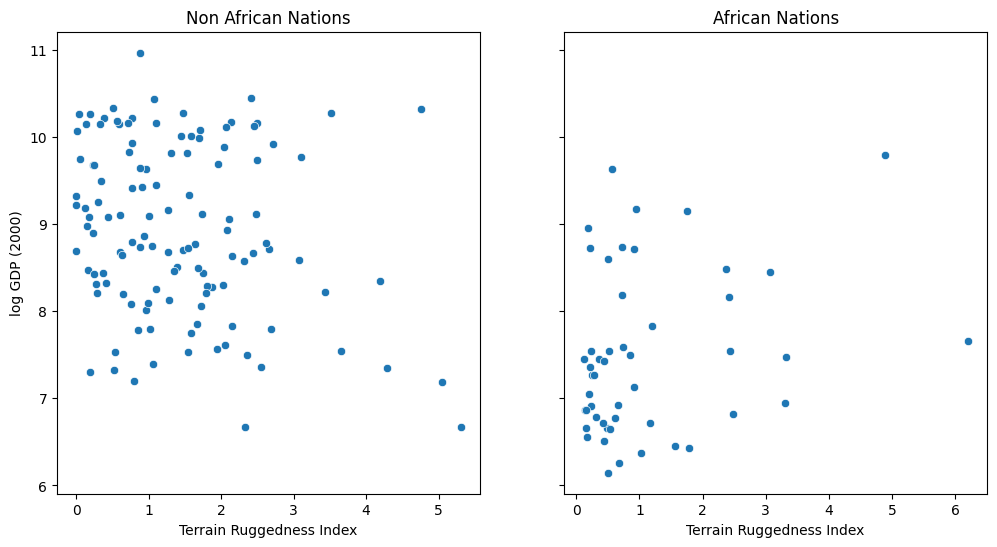

In [6]:
# visualize relationship between ruggedness and gdp
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

# Representation of a (Bayesian, in this case) linear regression model in pyro

```mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness```

We will be seeing whether ruggedness impacts GDP, both in and outside Africa, and whether ruggedness has different impacts on GDP depending on whether a country is in Africa

In [7]:
# define a Bayesian linear regression model in Pyro

def simple_model(is_cont_africa, ruggedness, log_gdp=None):
    # define paramaters of the model
    # most are initialized to be random noise
    a = pyro.param("a", lambda: torch.randn(()))
    b_a = pyro.param("bA", lambda: torch.randn(()))
    b_r = pyro.param("bR", lambda: torch.randn(()))
    b_ar = pyro.param("bAR", lambda: torch.randn(()))
    # we initialize sigma (variance) as a vector of ones, and constrain it to be non-negative using Pyro's constraints module
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)

    # specify the regression model
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    # defines an observed variable called "obs", whose observations are from log_gdp,
    #   and whose distirbution is normal centered around mean (specified above)
    #   with a variance of sigma
    # using pyro.plate allows the plate notation to be visualized; see below
    # also, it vectorizes sampling operations across all samples of ruggedness and log_gdp
    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

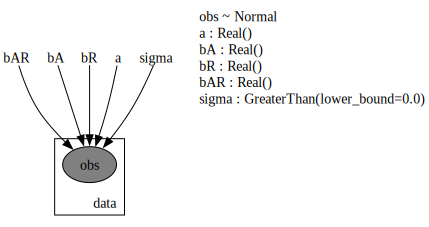

In [8]:
# visualize the plate notation of the model using pyro.render_model
pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp), 
                  render_distributions=True, render_params=True)


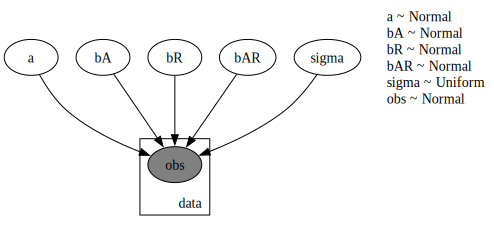

In [21]:
# now we define a more Bayesian model with normal priors on the parameters, except for sigma
def model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))  # dist.InverseGamma(1, 1))

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True)

# Defining the variational family

Pyro usually optimizes models using variational inference, though it supports other techniques as well. In Pyro, the variational distribution is called a "guide", and the user can either specify their own or use one of Pyro's prepackaged ones. We will specify a custom guide for our Bayesian linear regression below.

In [22]:
# custom guide (variational family)
# we will use a guide that models the distribution of unobserved parameters
#   in the model as a Gaussian with diagonal covariance, i.e. a mean-field approximation
def custom_guide(is_cont_africa, ruggedness, log_gdp=None):
    # we'll define the "location" and "scale" (mean and variance) of each parameter in the model,
    #   often initializing the location as 0s. the scale must be non-negative
    a_loc = pyro.param('a_loc', lambda: torch.tensor(0.))
    a_scale = pyro.param('a_scale', lambda: torch.tensor(1.), constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', lambda: torch.tensor(0.))
    weights_loc = pyro.param('weights_loc', lambda: torch.randn(3))
    weights_scale = pyro.param('weights_scale', lambda: torch.ones(3),
                               constraint=constraints.positive)
    
    # now we sample the parameters from these
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.LogNormal(sigma_loc, torch.tensor(0.05)))  # fixed scale for simplicity
    return {"a": a, "b_a": b_a, "b_r": b_r, "b_ar": b_ar, "sigma": sigma}


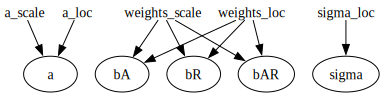

In [23]:
# use pyro.render_model to visualize custom_guide
pyro.render_model(custom_guide, model_args=(is_cont_africa, ruggedness, log_gdp), render_params=True)

In [24]:
# pyro also has a variety of "autoguides" that automatically generate some popular guides for us
# pyro's AutoNormal guide is exactly the same as the one we hand-wrote above
auto_guide = pyro.infer.autoguide.AutoNormal(model)

# Training / Optimization
Here we optimize the model using Stochastic Variational Inference (SVI).
Pyro has many different optimizers and many different ELBO estimators.
In this tutorial we use Trace_ELBO, which is always safe to use.

In [25]:
# use the Adam optimizer and the Trace ELBO, then set up the SVI optimizer
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

In [26]:
# now train the model for a bunch of steps and log the results
losses = []
for step in range(1000 if not smoke_test else 2):
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

Elbo loss: 531.9670842289925
Elbo loss: 362.35303604602814
Elbo loss: 268.4431039094925
Elbo loss: 253.51740729808807
Elbo loss: 248.9657066464424
Elbo loss: 247.84016251564026
Elbo loss: 250.7553037405014
Elbo loss: 250.72654581069946
Elbo loss: 251.8609773516655
Elbo loss: 248.02578955888748


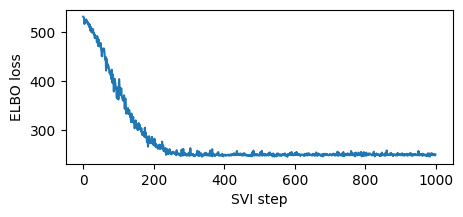

In [27]:
# print losses at each step
plt.figure(figsize=(5,2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [28]:
# display the final trained values of the guide parameter values
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

a 0.66135216
bA 0.2669241
bR 0.06167726
bAR 0.6213173
sigma 1.0
a_loc 0.0
a_scale 1.0
sigma_loc 0.0
weights_loc [0.66135216 0.2669241  0.06167726]
weights_scale [1. 1. 1.]
AutoNormal.locs.a 9.17453
AutoNormal.scales.a 0.07737893
AutoNormal.locs.bA -1.8424681
AutoNormal.scales.bA 0.1340488
AutoNormal.locs.bR -0.18617758
AutoNormal.scales.bR 0.047453146
AutoNormal.locs.bAR 0.30444533
AutoNormal.scales.bAR 0.07962455
AutoNormal.locs.sigma -2.239725
AutoNormal.scales.sigma 0.061868716


In [29]:
# we now revisit the question of how robust the relationship between terrain ruggedness and gdp
#   is against the uncertainty in the model parameter estimates
# to do so we plot the distribution of the slope of the log GDP given terrain ruggedness for
#   countries within and outside africa
# we represent these two distributions with samples drawn from our trained guide
# the pyro.plate statement vectorizes the 800 sample operations
with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(is_cont_africa, ruggedness)

gamma_within_africa = samples["bR"] + samples["bAR"]
gamma_outside_africa = samples["bR"]  # we only have the interaction term if is_cont_africa=1

StopIteration: 

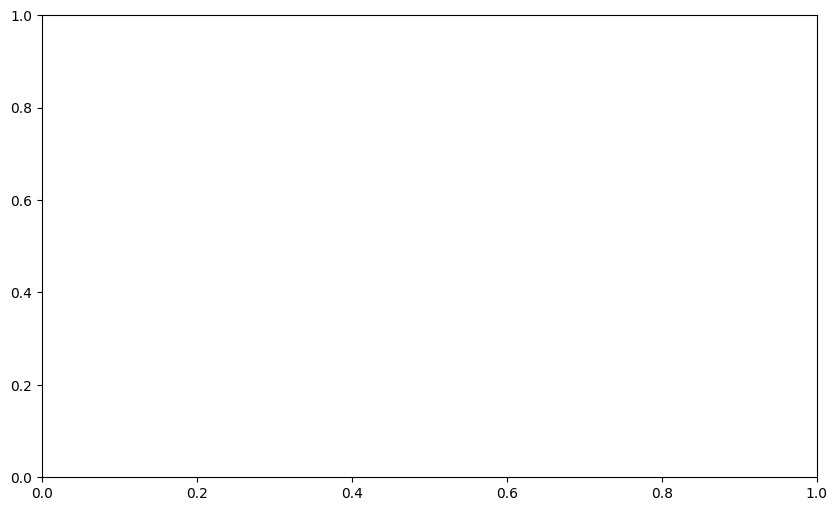

In [30]:
# plot the results
fig = plt.figure(figsize=(10, 6))
sns.histplot(gamma_within_africa.detach().cpu().numpy(), kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), kde=True, stat="density", label="Non-African nations", color="orange")
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()

# Model Evaluation and Posterior Predictive

Here we will see how trustworthy our model is by drawing samples from the posterior predictive distribution.
We will then rivisit our model with a less restrictive (non mean field) variational family -- the multivariate normal distribution.

In [31]:
# use Pyro's infer.Predictive model to infer posterior predictive 
#   (approximated by our learned variational distribution, i.e. auto_guide)
#   , then draw samples from it
predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=800)
svi_samples = predictive(is_cont_africa, ruggedness, log_gdp=None)
svi_gdp = svi_samples["obs"]

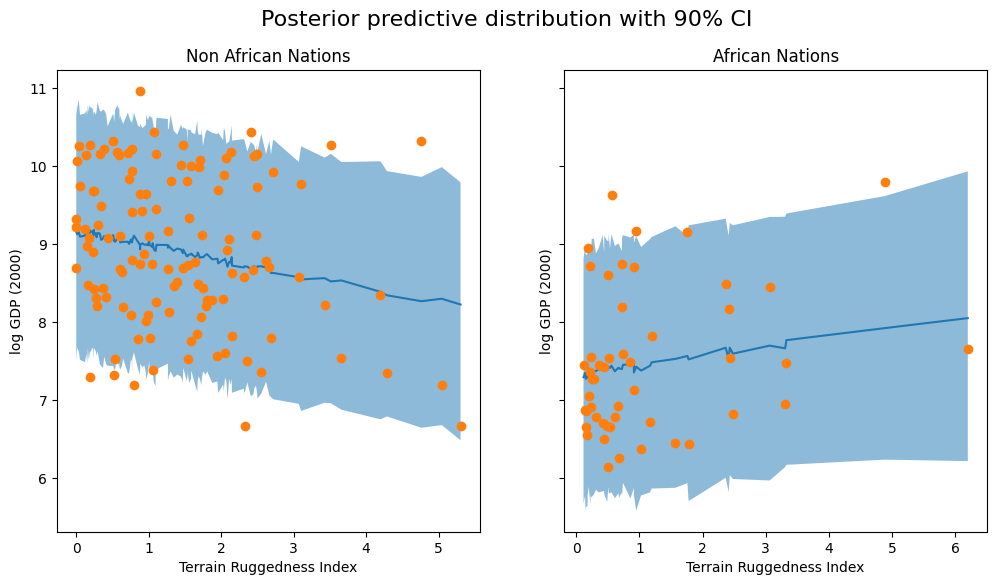

In [32]:
# plot the 90% credible interval of the posterior predcitive distribution for each country
predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": svi_gdp.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_gdp.kthvalue(int(len(svi_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_gdp.kthvalue(int(len(svi_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})
african_nations = predictions[predictions["cont_africa"] == 1].sort_values(by=["rugged"])
non_african_nations = predictions[predictions["cont_africa"] == 0].sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["y_perc_5"], non_african_nations["y_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations")

ax[1].plot(african_nations["rugged"], african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"], african_nations["y_perc_5"], african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(african_nations["rugged"], african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations");

#### Interesting tidbit on sigma prior...

I noticed that if I do an inverse gamma (1, 1) prior for sigma in the model instead of a uniform (0, 10) prior, the slope of the non-African countries changes, and is actually also positive, which is quite interesting...

# Multivariate Normal Variational Family Auto-Guide
Now we will experiment with a guide that is not mean-field, but rather multivariate normal, allowing covariance between the latent parameters. Normally to do this we'd need to combine all the latent variables into a single pyro.Sample command from a pyro.dist.MultivariateNormal dsitribution, choose an implementation of constrain() to make sure the covariance matrix is positive semidefinite, etc.

Instead we avoid all this trouble by using Pyro's pyro.infer.autoguide.AutoMultivariateNormal() method.

In [33]:
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)

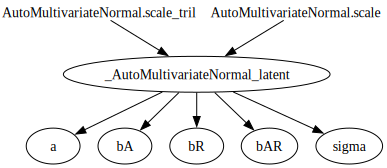

In [34]:
# render the model. note how the guide's parameters are now all under one bubble, 
#   with the inputs of the mean and covariance parameters of the MVN
pyro.render_model(mvn_guide, model_args=(is_cont_africa, ruggedness, log_gdp), render_params=True)

Elbo loss: 551.6917690038681
Elbo loss: 376.3236227631569
Elbo loss: 299.3336606025696
Elbo loss: 252.55478286743164
Elbo loss: 250.0805140733719
Elbo loss: 247.40916460752487
Elbo loss: 247.794085085392
Elbo loss: 248.06149011850357
Elbo loss: 247.9917523264885
Elbo loss: 248.67935466766357


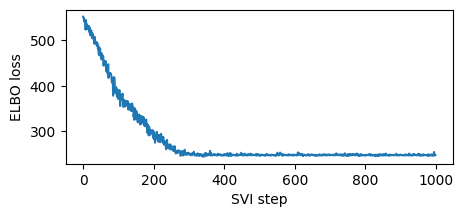

In [36]:
# now we re-run our inference and evaluation code from before
# the only difference is we re-use the samples from the guide for learning the posterior predictive
#   instead of passing in the guide itself and thereby re-drawing them, which we did before
import pyro.infer


pyro.clear_param_store()
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
svi = pyro.infer.SVI(model, mvn_guide, pyro.optim.Adam({'lr': 0.02}), pyro.infer.Trace_ELBO())

losses = []
for step in range(1000 if not smoke_test else 2):
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

with pyro.plate("samples", 800, dim=-1):
    mvn_samples = mvn_guide(is_cont_africa, ruggedness)

mvn_gamma_within_africa = mvn_samples["bR"] + mvn_samples["bAR"]
mvn_gamma_outside_africa = mvn_samples["bR"]

assert "obs" not in mvn_samples
mvn_predictive = pyro.infer.Predictive(model, posterior_samples=mvn_samples)
mvn_predictive_samples = mvn_predictive(is_cont_africa, ruggedness, log_gdp=None)

mvn_gdp = mvn_predictive_samples["obs"]


OptionError: "No such keys(s): 'mode.use_inf_as_null'"

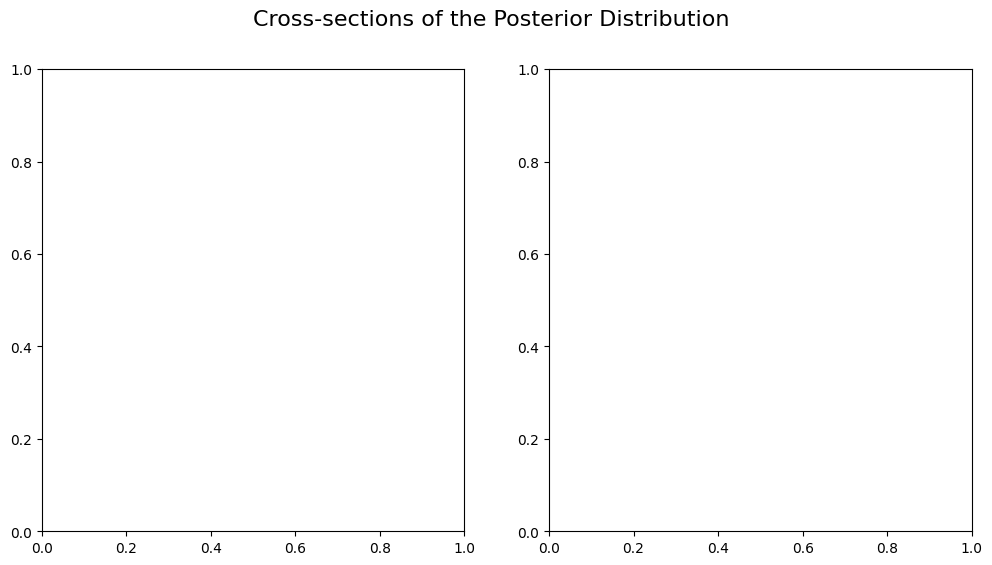

In [37]:
# now we compare the posterior inferred by the mean field "diagonal normal" guide vs the MVN guide
# note that the MVN posterior (orange) is more dispersed and can model correlations between parameters
#  (thus the diagonal shape)
svi_samples = {k: v.detach().cpu().numpy() for k, v in samples.items()}
svi_mvn_samples = {k: v.detach().cpu().numpy() for k, v in mvn_samples.items()}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=svi_samples["bA"], y=svi_samples["bR"], ax=axs[0], bw_adjust=4 )
sns.kdeplot(x=svi_mvn_samples["bA"], y=svi_mvn_samples["bR"], ax=axs[0], shade=True, bw_adjust=4)
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.8, -0.9), ylim=(-0.6, 0.2))

sns.kdeplot(x=svi_samples["bR"], y=svi_samples["bAR"], ax=axs[1],bw_adjust=4 )
sns.kdeplot(x=svi_mvn_samples["bR"], y=svi_mvn_samples["bAR"], ax=axs[1], shade=True, bw_adjust=4)
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.55, 0.2), ylim=(-0.15, 0.85))


for label, color in zip(["SVI (Diagonal Normal)", "SVI (Multivariate Normal)"], sns.color_palette()[:2]):
    plt.plot([], [],
                label=label, color=color)

fig.legend(loc='upper right')

StopIteration: 

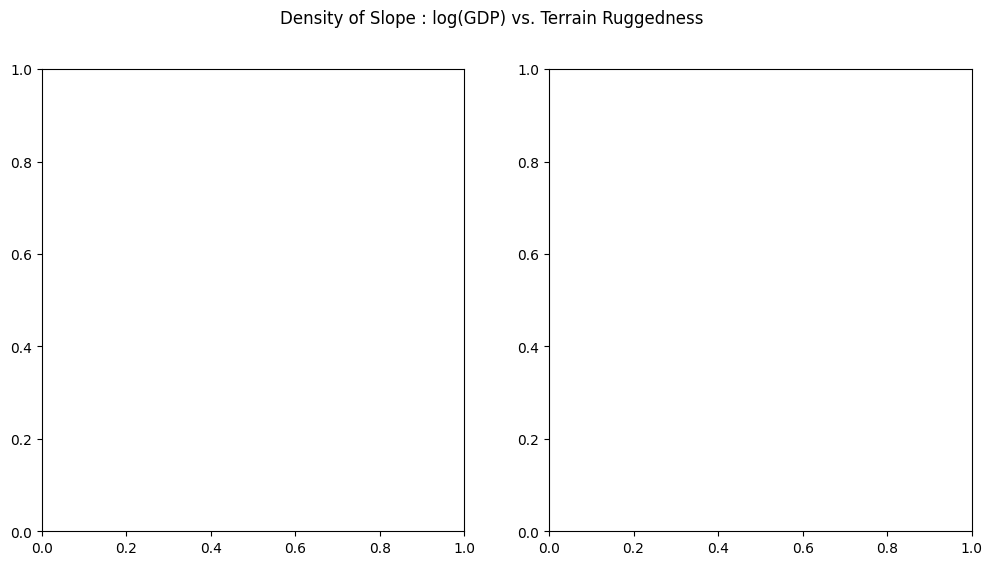

In [38]:
# now we redo our histogram showing the posterior uncertainty of the ruggedness-GDP coefficient
#   inside and outside africa.
# note that with the MVN guide, the posterior uncertainty is now the same both inside and outside africa.
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

sns.histplot(gamma_within_africa.detach().cpu().numpy(), ax=axs[0], kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), ax=axs[0], kde=True, stat="density", color="orange", label="Non-African nations")
axs[0].set(title="Mean field", xlabel="Slope of regression line", xlim=(-0.6, 0.6), ylim=(0, 11))

sns.histplot(mvn_gamma_within_africa.detach().cpu().numpy(), ax=axs[1], kde=True, stat="density", label="African nations")
sns.histplot(mvn_gamma_outside_africa.detach().cpu().numpy(), ax=axs[1], kde=True, stat="density", color="orange", label="Non-African nations")
axs[1].set(title="Full rank", xlabel="Slope of regression line", xlim=(-0.6, 0.6), ylim=(0, 11))

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

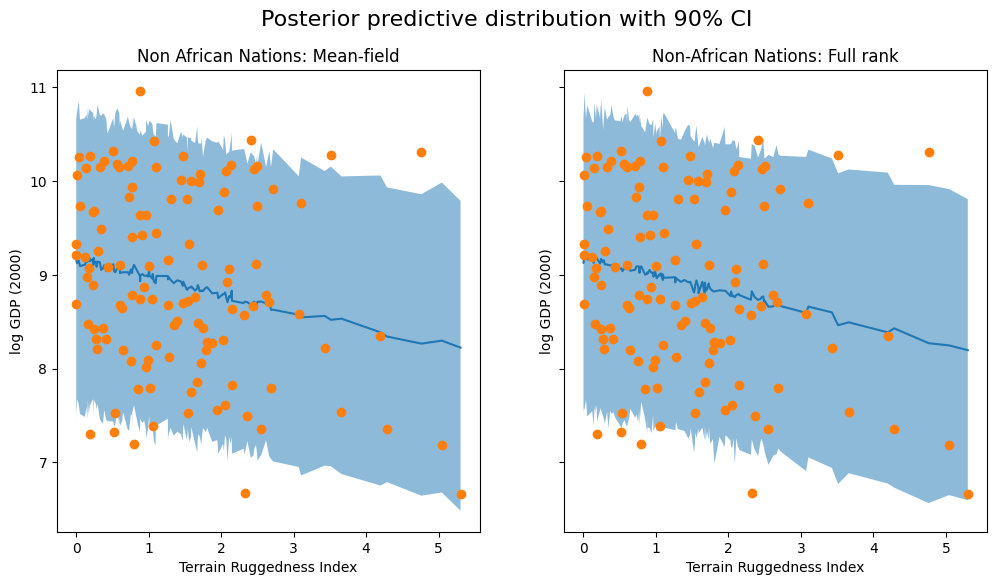

In [39]:
# re-visualize the 90% credible interval of the posterior predictive -- note how both inside and outside africa
#   slopes are negative (and similar) now
mvn_predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": mvn_gdp.mean(dim=0).detach().cpu().numpy(),
    "y_perc_5": mvn_gdp.kthvalue(int(len(mvn_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": mvn_gdp.kthvalue(int(len(mvn_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})
mvn_non_african_nations = mvn_predictions[mvn_predictions["cont_africa"] == 0].sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["y_perc_5"], non_african_nations["y_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations: Mean-field")

ax[1].plot(mvn_non_african_nations["rugged"], mvn_non_african_nations["y_mean"])
ax[1].fill_between(mvn_non_african_nations["rugged"], mvn_non_african_nations["y_perc_5"], mvn_non_african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(mvn_non_african_nations["rugged"], mvn_non_african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non-African Nations: Full rank");